In [1]:
# ! pip install colorcet

In [2]:
import torch
import os
import sys
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from torchvision.io import ImageReadMode, read_image
from torchvision.transforms import CenterCrop, ConvertImageDtype, Normalize, Resize
from torchvision.transforms.functional import InterpolationMode
from datasets import load_dataset, Dataset
from transformers import VisionEncoderDecoderModel
from transformers import AutoTokenizer
from transformers import AutoImageProcessor
import pickle

sys.path.append('.')
sys.path.append('..')
sys.path.append('./utils')

from _utils import *
from chexbert import *

import numpy as np

mimic_dir = '../conformal_align/codes/cxr/physionet.org/files/mimic-cxr-resized-224/'
ckpt = "./models/trained_p101112"

split_name = 'dev'

num_gens = 10

# plot
import seaborn as sns
sns.set_theme()
sns.set_context("notebook")
import matplotlib.pyplot as plt
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

/Users/yugui/opt/anaconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/yugui/opt/anaconda3/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/yugui/opt/anaconda3/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/yugui/opt/anaconda3/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.

# Load fine-tuned VLM

In [3]:
# load model
print("Loading model...")
trained_model = VisionEncoderDecoderModel.from_pretrained(ckpt)

print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(
        "gpt2",
        use_fast=True
    )
tokenizer.eos_token = tokenizer.decode(tokenizer.eos_token_id)
tokenizer.bos_token = tokenizer.decode(tokenizer.bos_token_id)
tokenizer.pad_token = tokenizer.eos_token

print("Loading image processor...")
image_processor = AutoImageProcessor.from_pretrained(
        "google/vit-base-patch16-224-in21k"
)


# Load dataset
print("Loading dataset...")
base = "./ap_pa_per_dicom_id"
dataset = load_dataset(
    "json",
    data_files={
        "train": os.path.join(base, "train.jsonl"),
        "dev": os.path.join(base, "dev.jsonl"),
        "validate": os.path.join(base, "validate.jsonl"),
        "test": os.path.join(base, "test.jsonl"),
    }
)


data_sub1 = dataset['dev']
data_sub2 = dataset['test']
dt1 = [data_sub1[i] for i in range(len(data_sub1))]
dt2 = [data_sub2[i] for i in range(len(data_sub2))]
dt1.extend(dt2)
data_sub = Dataset.from_list(dt1)

Loading model...


/Users/yugui/opt/anaconda3/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Loading tokenizer...
Loading image processor...
Loading dataset...


## an example of report generating

In [4]:
test_sub = data_sub[[1,10]]

true_finding = [''.join(text.split(get_before_findings(text))).strip()  for text in test_sub['report']]
test_prompts_sub = [get_before_findings(text) for text in test_sub['report']]
tokenizer.padding_side = "left"
test_input_ids_sub, test_attention_masks_sub = tokenizer(test_prompts_sub, return_tensors="pt", padding=True).values()

images_sub = [read_image(os.path.join(mimic_dir, image_path), mode=ImageReadMode.RGB) for image_path in test_sub['image_path']]
image_size = image_processor.size['height']
inference_image_transformations = Transform(image_size, image_processor.image_mean, image_processor.image_std)
inference_image_transformations = torch.jit.script(inference_image_transformations)

def inference_jit_image_processor(images):
    return torch.stack([inference_image_transformations(image) for image in images], dim=0)

test_pixel_values_sub = inference_jit_image_processor(images_sub)

test_sub["pixel_values"] = test_pixel_values_sub
test_sub["decoder_input_ids"] = test_input_ids_sub

input_length = test_input_ids_sub.shape[1]

input_datum = {
    "pixel_values": test_pixel_values_sub,
    "decoder_input_ids": test_input_ids_sub,
    "decoder_attention_mask": test_attention_masks_sub,
}

In [5]:
import torch.nn.functional as F
output = trained_model.generate(
        **input_datum, 
        max_length=512, 
        do_sample=True, 
        num_return_sequences=1
        )

texts = tokenizer.batch_decode(output, skip_special_tokens=True)
for t in texts:
    print("--------------")
    print(t)

/Users/yugui/opt/anaconda3/lib/python3.9/site-packages/transformers/generation/utils.py:1518: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


--------------
                                 FINAL REPORT
 REASON FOR EXAMINATION:  Evaluation of the patient with fever first day after
 repair of umbilical hernia.
 
 PA and lateral upright chest radiographs were reviewed in comparison to ___.
 
 Right pleural effusion is partially loculated, moderate associated with
 bibasal atelectasis.  No appreciable pneumothorax is seen.  No new
 consolidations demonstrated, but the consolidations in the lung bases might
 potentially represent at least in part infectious process.
FINDINGS:
 
 Right pleural effusion is partially loculated, substantial associated with
 bibasal atelectasis.  Right PICC line tip is at the level of mid SVC.

--------------
                                 FINAL REPORT
 INDICATION:  ___-year-old female with chest pain, rule out infiltrate.
 
 COMPARISON:  PA and lateral chest radiograph from ___.
 
 FINDINGS: 
 
 There are prominent interstitial markings bilaterally. There is no
 focal consolidation or pneumothorax

# Load generated report

In [6]:
path = './output/trained_cxr_10/01.pkl'
with open(path, 'rb') as f:
    sequences = pickle.load(f)
print(len(sequences))
print(sequences[0]['question'])

10000
                                 FINAL REPORT
 EXAMINATION:  CHEST (PORTABLE AP)
 
 INDICATION:  ___ year old man with GI bleed, intubation  // ? aspiration      ?
 aspiration
 
 IMPRESSION:


In [16]:
import numpy as np
tau = 0.5918367346938775
path = f'./output/trained_cxr_10/uq_result/scores_{tau}.csv'
summ = pd.read_csv(path)
path = f'./output/trained_cxr_10/uq_result/labels_{tau}.csv'
lab = np.array(pd.read_csv(path).iloc[:,0].to_list())

ids = summ.iloc[:,0].to_list()
summ_mean = 1 - np.array(summ.mean(1).to_list())
rk = summ_mean.argsort()
lab = lab[rk]
# 1500, 7000, 1556, 7330
id_min = rk[1500]
id_max = rk[7000]
id_seq = [sequences[ii]['id'] for ii in range(len(sequences))]

id1 = id_seq.index(ids[id_min])
print(sequences[id1]['question'])
print(sequences[id1]['chexbert_score_generations'])
assert  data_sub[id1]['dicom_id'] == sequences[id1]['id']
print(data_sub[id1]['image_path'])
print(f"Predicted alignment score: {summ_mean[id_min]}")
print(f"True label: {lab[id_min]}")
print("\nTrue report:\n")
print(''.join(sequences[id1]['answer'].split('\n')).strip())
print('-------------------------------------------\nGenerated report:\n')
print(''.join(sequences[id1]['most_likely_generation'][1:].split('\n')).strip())
print('===========================================')
id2 = id_seq.index(ids[id_max])
print(sequences[id2]['question'])
print(sequences[id2]['chexbert_score_generations'])
assert  data_sub[id2]['dicom_id'] == sequences[id2]['id']
print(data_sub[id2]['image_path'])
print(f"Predicted alignment score: {summ_mean[id_max]}")
print(f"True label: {lab[id_max]}")
print("\nTrue report:\n")
print(''.join(sequences[id2]['answer'].split('\n')).strip())
print('-------------------------------------------\nGenerated report:\n')
print(''.join(sequences[id2]['most_likely_generation'][1:].split('\n')).strip())

                                 FINAL REPORT
 EXAMINATION:  CHEST (PORTABLE AP)
 
 INDICATION:  ___ year old woman with concern for neg pressure pulm edema  //
 eval for pulm edema      eval for pulm edema
 
 IMPRESSION:
[12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0]
2.0.0/files/p12/p12416498/s59143157/9f3e64ab-c62ed956-4c8d838f-98bf92ee-17fabdb0.jpg
Predicted alignment score: 0.19399999999999995
True label: 0.0

True report:

In comparison with the study of ___, there has been a substantial increase in opacifications diffusely involving both lungs.  Cardiac silhouette remains within normal limits an there is no evidence of pleural effusion. The appearance suggests diffuse pulmonary edema.  However, in the appropriate clinical setting, widespread pneumonia or even ARDS could be considered.
-------------------------------------------
Generated report:

In comparison with the study of ___, there is little overall change.  Again there is substantial enlargement of the cardi

/var/folders/vf/jr75r1v56hl9tgfz4rv6dh4r0000gn/T/ipykernel_3990/1939149189.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  summ_mean = 1 - np.array(summ.mean(1).to_list())


# Reproduce plots

## Results with varying reference sample size

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 115.84it/s]


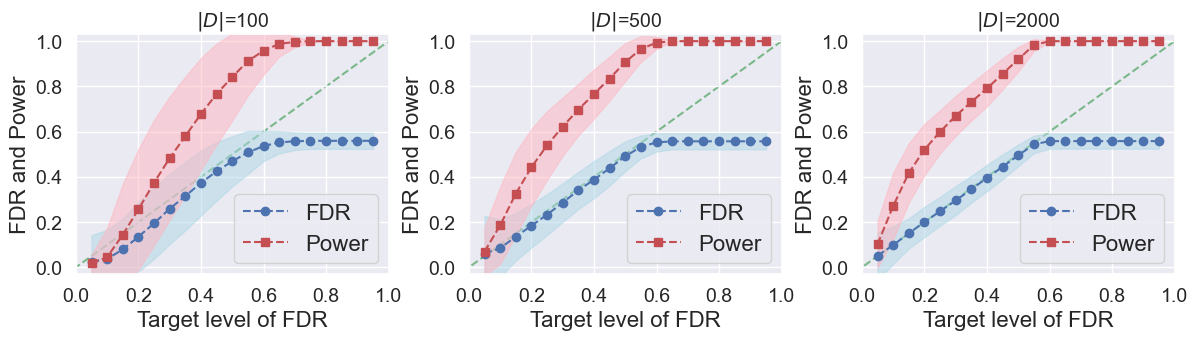

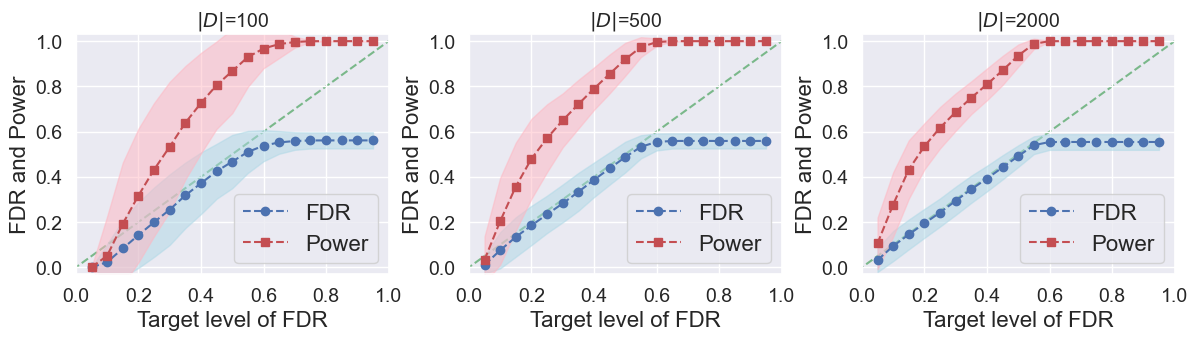

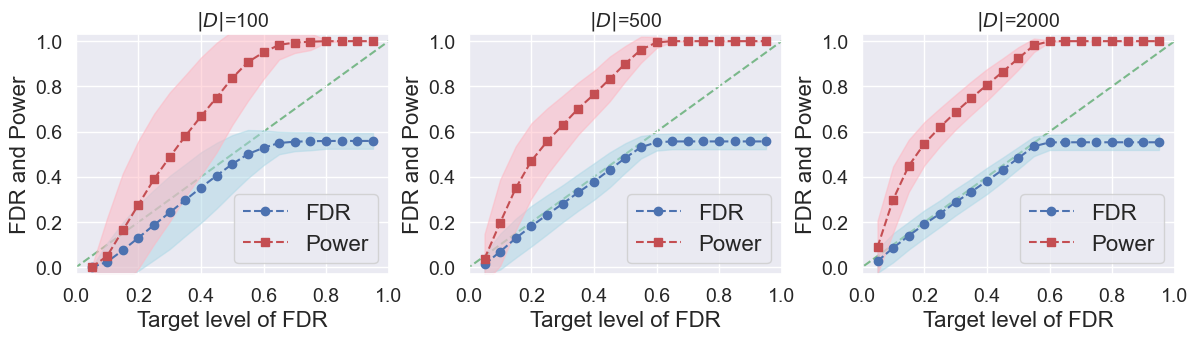

In [17]:
# for CXR: varying N

repN = 500
data = 'cxr'
model = 'trained'

for split_pr_tune in [0.2]:
    for split_pr in [0.5]:
        if split_pr + split_pr_tune<1:
            for uq_name in ['rf', 'logistic', 'xgbrf']:

                fig, ax = plt.subplots(1,3,figsize=(12, 3.2))
                fig.tight_layout()
                plt.subplots_adjust(hspace=0.3)

                par_path = f'./output/{model}_{data}_10'

                q_seq = np.round(np.linspace(0.05,0.95,19),2)
                train_size_seq = [100, 500, 2000]

                for i in tqdm(range(len(train_size_seq))):

                    N = train_size_seq[i]

                    path_fdr = os.path.join(par_path, f'uq_result/result/fdr_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
                    path_power = os.path.join(par_path, f'uq_result/result/power_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
                    path_fdr_std = os.path.join(par_path, f'uq_result/result/fdr_std_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
                    path_power_std = os.path.join(par_path, f'uq_result/result/power_std_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')

                    with open(path_fdr, 'rb') as f:
                        fdp_seq = pickle.load(f)
                    with open(path_power, 'rb') as f:
                        power_seq = pickle.load(f)
                    with open(path_fdr_std, 'rb') as f:
                        fdp_std = pickle.load(f)
                    with open(path_power_std, 'rb') as f:
                        power_std = pickle.load(f)
                        
                    if len(fdp_seq) > 20:
                        idx_ = np.arange(4,99,5)
                        fdp_seq = fdp_seq[idx_]
                        power_seq = power_seq[idx_]
                        fdp_std = fdp_std[idx_]
                        power_std = power_std[idx_]


                    ax[i].plot(q_seq, fdp_seq, 'bo--', label='FDR')
                    ax[i].plot(q_seq, power_seq, 'rs--', label='Power')
                    ax[i].fill_between(q_seq, fdp_seq-fdp_std, fdp_seq+fdp_std, alpha=0.5, 
                        edgecolor='lightblue', facecolor='lightblue')
                    ax[i].fill_between(q_seq, power_seq-power_std, power_seq+power_std, alpha=0.5, 
                        edgecolor='lightpink', facecolor='lightpink')
                
                    ax[i].set_xlabel("Target level of FDR")
                    ax[i].set_ylabel("FDR and Power")

                    lims = [
                        np.min([ax[i].get_xlim(), ax[i].get_ylim()]),  # min of both axes
                        np.max([ax[i].get_xlim(), ax[i].get_ylim()]),  # max of both axes
                    ]
                    ax[i].plot(lims, lims, 'g--', alpha=0.75, zorder=0)
                    ax[i].set_title(r'$|D|$=%s'%(N,))
                    ax[i].set_xlim(lims)
                    ax[i].set_ylim(lims)
                    ax[i].set_xlim((0,1))
                    ax[i].set_ylim((-0.03,1.03))
                    ax[i].legend(loc='best', prop = { "size": 16 })


                plot_dir = f'./plots/fdp_plot_{model}_{data}_{uq_name}_{split_pr_tune}_{split_pr}_{repN}.pdf'
                plt.savefig(plot_dir, dpi=400, bbox_inches='tight')


## Results with varying $\gamma_1$: sample size for hyper-parameters tuning

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 144.31it/s]


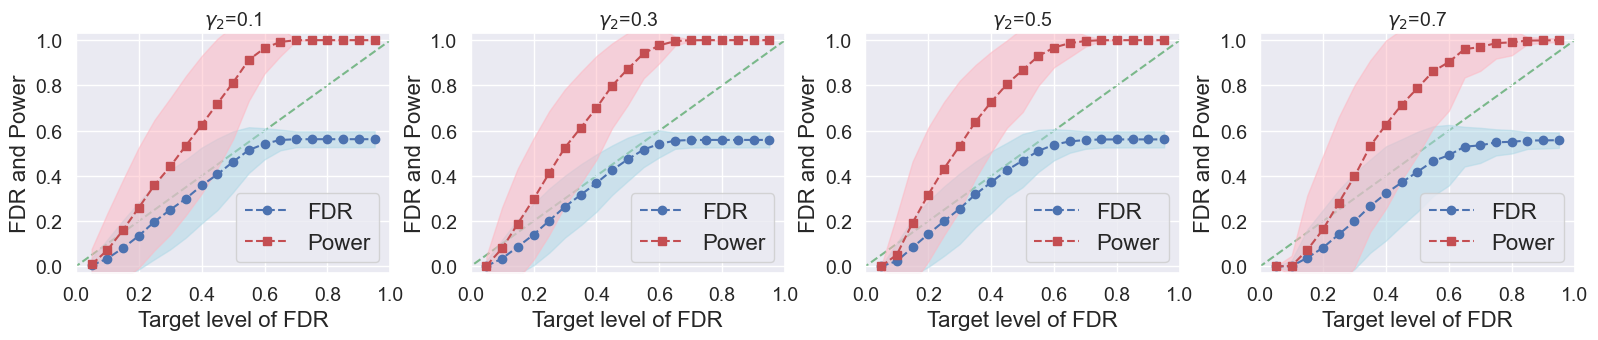

In [21]:
# for CXR: varying split_pr

repN = 500
data = 'cxr'
model = 'trained'
train_size_seq = [100]
pr_seq = [0.1,0.3,0.5,0.7]

for split_pr_tune in [0.2]:
    for N in train_size_seq:
        for uq_name in ['logistic']:

            fig, ax = plt.subplots(1,len(pr_seq),figsize=(4*len(pr_seq), 3.2))
            fig.tight_layout()
            plt.subplots_adjust(hspace=0.3)

            par_path = f'./output/{model}_{data}_10'

            q_seq = np.round(np.linspace(0.05,0.95,19),2)

            for i in tqdm(range(len(pr_seq))):
                # check split_pr + split_pr_tune<1

                split_pr = pr_seq[i]

                path_fdr = os.path.join(par_path, f'uq_result/result/fdr_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
                path_power = os.path.join(par_path, f'uq_result/result/power_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
                path_fdr_std = os.path.join(par_path, f'uq_result/result/fdr_std_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
                path_power_std = os.path.join(par_path, f'uq_result/result/power_std_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')

                with open(path_fdr, 'rb') as f:
                    fdp_seq = pickle.load(f)
                with open(path_power, 'rb') as f:
                    power_seq = pickle.load(f)
                with open(path_fdr_std, 'rb') as f:
                    fdp_std = pickle.load(f)
                with open(path_power_std, 'rb') as f:
                    power_std = pickle.load(f)
                    
                if len(fdp_seq) > 20:
                    idx_ = np.arange(4,99,5)
                    fdp_seq = fdp_seq[idx_]
                    power_seq = power_seq[idx_]
                    fdp_std = fdp_std[idx_]
                    power_std = power_std[idx_]


                ax[i].plot(q_seq, fdp_seq, 'bo--', label='FDR')
                ax[i].plot(q_seq, power_seq, 'rs--', label='Power')
                ax[i].fill_between(q_seq, fdp_seq-fdp_std, fdp_seq+fdp_std, alpha=0.5, 
                    edgecolor='lightblue', facecolor='lightblue')
                ax[i].fill_between(q_seq, power_seq-power_std, power_seq+power_std, alpha=0.5, 
                    edgecolor='lightpink', facecolor='lightpink')

                ax[i].set_xlabel("Target level of FDR")
                ax[i].set_ylabel("FDR and Power")

                lims = [
                    np.min([ax[i].get_xlim(), ax[i].get_ylim()]),  # min of both axes
                    np.max([ax[i].get_xlim(), ax[i].get_ylim()]),  # max of both axes
                ]
                ax[i].plot(lims, lims, 'g--', alpha=0.75, zorder=0)
                ax[i].set_title(r'$\gamma_2$=%s'%(split_pr,))
                ax[i].set_xlim(lims)
                ax[i].set_ylim(lims)
                ax[i].set_xlim((0,1))
                ax[i].set_ylim((-0.03,1.03))
                ax[i].legend(loc='best', prop = { "size": 16 })

            plot_dir = f'./plots/fdp_plot_gamma_2_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{repN}.pdf'
            plt.savefig(plot_dir, dpi=400, bbox_inches='tight')


## Results with varying $\gamma_2$: sample size for training the alignment score predictor

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 135.22it/s]


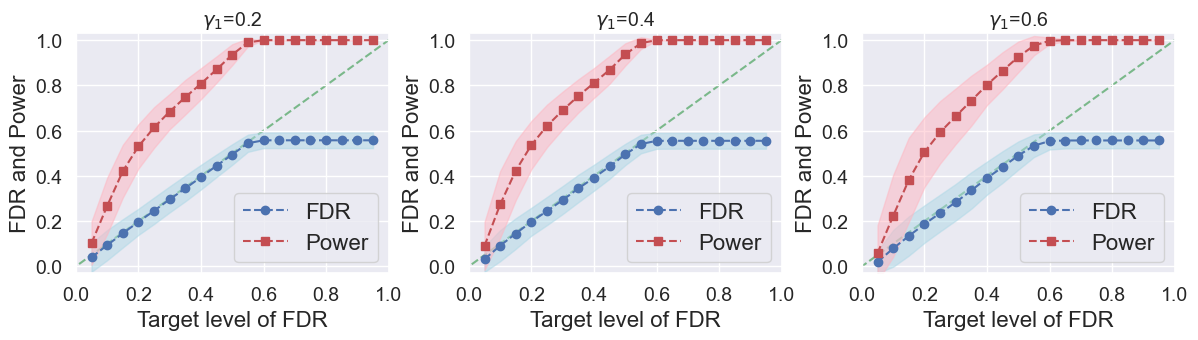

In [19]:
# for CXR: varying split_pr

repN = 500
data = 'cxr'
model = 'trained'
train_size_seq = [2000]
tune_pr_seq = [0.2,0.4,0.6]

for split_pr in [0.3]:
    for N in train_size_seq:
        for uq_name in ['logistic']:

            fig, ax = plt.subplots(1,len(tune_pr_seq),figsize=(4*len(tune_pr_seq), 3.2))
            fig.tight_layout()
            plt.subplots_adjust(hspace=0.3)

            par_path = f'./output/{model}_{data}_10'

            q_seq = np.round(np.linspace(0.05,0.95,19),2)

            for i in tqdm(range(len(tune_pr_seq))):
                # check split_pr + split_pr_tune<1

                split_pr_tune = tune_pr_seq[i]

                path_fdr = os.path.join(par_path, f'uq_result/result/fdr_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
                path_power = os.path.join(par_path, f'uq_result/result/power_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
                path_fdr_std = os.path.join(par_path, f'uq_result/result/fdr_std_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
                path_power_std = os.path.join(par_path, f'uq_result/result/power_std_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')

                with open(path_fdr, 'rb') as f:
                    fdp_seq = pickle.load(f)
                with open(path_power, 'rb') as f:
                    power_seq = pickle.load(f)
                with open(path_fdr_std, 'rb') as f:
                    fdp_std = pickle.load(f)
                with open(path_power_std, 'rb') as f:
                    power_std = pickle.load(f)
                    
                if len(fdp_seq) > 20:
                    idx_ = np.arange(4,99,5)
                    fdp_seq = fdp_seq[idx_]
                    power_seq = power_seq[idx_]
                    fdp_std = fdp_std[idx_]
                    power_std = power_std[idx_]

                ax[i].plot(q_seq, fdp_seq, 'bo--', label='FDR')
                ax[i].plot(q_seq, power_seq, 'rs--', label='Power')
                ax[i].fill_between(q_seq, fdp_seq-fdp_std, fdp_seq+fdp_std, alpha=0.5, 
                    edgecolor='lightblue', facecolor='lightblue')
                ax[i].fill_between(q_seq, power_seq-power_std, power_seq+power_std, alpha=0.5, 
                    edgecolor='lightpink', facecolor='lightpink')
                
                ax[i].set_xlabel("Target level of FDR")
                ax[i].set_ylabel("FDR and Power")

                lims = [
                    np.min([ax[i].get_xlim(), ax[i].get_ylim()]),  # min of both axes
                    np.max([ax[i].get_xlim(), ax[i].get_ylim()]),  # max of both axes
                ]
                ax[i].plot(lims, lims, 'g--', alpha=0.75, zorder=0)
                ax[i].set_title(r'$\gamma_1$=%s'%(split_pr_tune,))
                ax[i].set_xlim(lims)
                ax[i].set_ylim(lims)
                ax[i].set_xlim((0,1))
                ax[i].set_ylim((-0.03,1.03))
                ax[i].legend(loc='best', prop = { "size": 16 })


            plot_dir = f'./plots/fdp_plot_gamma_1_{model}_{data}_{uq_name}_{N}_{split_pr}_{repN}.pdf'
            plt.savefig(plot_dir, dpi=400, bbox_inches='tight')


## Effect of features in alignment score prediction

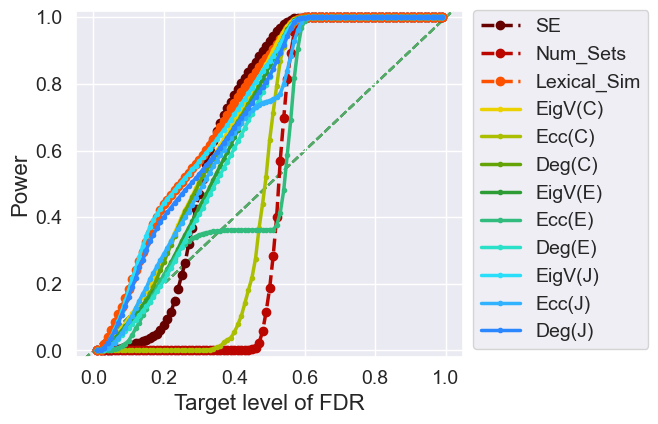

In [34]:
import colorcet as cc
from matplotlib.cm import get_cmap
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# ROC
data = 'cxr'
model = 'trained'
N = 2000
uq_name = 'logistic'
split_pr_tune = 0.2
split_pr = 0.5
repN = 500
uq_list = [
        'generations|numsets', 
        'lexical_sim',
        'generations|spectral_eigv_clip|disagreement_w',
        'generations|eccentricity|disagreement_w',
        'generations|degree|disagreement_w',
        'generations|spectral_eigv_clip|agreement_w',
        'generations|eccentricity|agreement_w',
        'generations|degree|agreement_w',
        'generations|spectral_eigv_clip|jaccard',
        'generations|eccentricity|jaccard',
        'generations|degree|jaccard',
        'semanticEntropy|unnorm', 
]
def name_map(v):
    if v == 'self_prob': return "Self_Eval"
    if v == 'lexical_sim': return "Lexical_Sim"
    v = v.replace("|numsets", "|Num_Sets")
    v = v.replace("|disagreement_w", "|(C)")
    v = v.replace("|agreement_w", "|(E)")
    v = v.replace("|jaccard", "|(J)")
    v = v.replace("spectral_eigv_clip|", "EigV")
    v = v.replace("eccentricity|", "Ecc")
    v = v.replace("degree|", "Deg")
    return {'semanticEntropy|unnorm': 'SE',
            'blind': 'Basse Accuracy'}.get(v,v)
    return v

q_seq = np.round(np.linspace(0.01,0.99,99),2)

fig, ax = plt.subplots(1,1,figsize=(5, 4.5))
    
par_path = f'./output/{model}_{data}_10'
path_fdr = os.path.join(par_path, f'uq_result/result/uq_fdr_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
path_power = os.path.join(par_path, f'uq_result/result/uq_power_{model}_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pkl')
with open(path_fdr, 'rb') as f:
    fdr_uq = pickle.load(f)
with open(path_power, 'rb') as f:
    power_uq = pickle.load(f)

idx_seq = [len(fdr_uq)-1] + [i for i in range(len(fdr_uq)-1)]
for i in range(len(idx_seq)):
    i_ = idx_seq[i]
    fdp_seq = fdr_uq[i_]
    power_seq = power_uq[i_]
    uq_nam = name_map(uq_list[i_])
    uq_nam = uq_nam.split('generations|')[-1]
    
    if uq_nam == 'Self_Eval':
        color = 'black'
        mark = 's'
        lty = '-'
    elif uq_nam in ['Num_Sets', 'SE', 'Lexical_Sim']:
        color = cc.fire[50*(i+1)]
        mark = 'o'
        lty = '--'
    else:
        color = cc.CET_C6[15*i]
        mark = '.'
        lty = '-'

    val = "Power"
    if val == 'FDR':
        val_seq = fdp_seq
    else:
        val_seq = power_seq
    ax.plot(q_seq, val_seq, linestyle=lty, marker=mark, markersize=6, linewidth=2.5, label=uq_nam, c=color)
    ax.set_xlabel("Target level of FDR")
    ax.set_ylabel(val)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'g--', alpha=0.75, zorder=0)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_ylim((-0.02,1.02))

ax.legend(loc='best',bbox_to_anchor=(1, 1.03))

plt.savefig(f'./plots/ROC_{val}_plot_{data}_{uq_name}_{N}_{split_pr_tune}_{split_pr}_{repN}.pdf', dpi=400, bbox_inches='tight')